<a href="https://colab.research.google.com/github/AndBoyS/PythonUni/blob/master/Car_parts_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Reload environment after pip install
!pip install -U segmentation-models-pytorch albumentations --user 

     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 102 kB 29.6 MB/s 
     |████████████████████████████████| 58 kB 8.9 MB/s 
     |████████████████████████████████| 376 kB 61.6 MB/s 
     |████████████████████████████████| 47.7 MB 160 kB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=efc4e5ed19d0b581303c4208cd6d663a4dc4aca36f2fc2755f0df49b27291620
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=7717d9b6d495239a3ef1665bbd4cf547a9a8773ad7e591658bca89a1781d9b68
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [1]:
import os
from pathlib import Path
import re

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

%load_ext autoreload
%autoreload 2

In [2]:
base_dir = Path('drive/My Drive/АвтоСтрах')
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    sys.path.append(str(base_dir))

#base_dir = Path('car_insur')
data_dir = base_dir / 'data'/ 'segmentation_renders_solaris'

In [3]:
import segmentation
from dataset import Dataset, visualize

In [5]:
CLASSES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24]

image_idx = range(len(list(data_dir.glob('render_*'))))
train_idx, test_idx = train_test_split(image_idx, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.6, random_state=42)

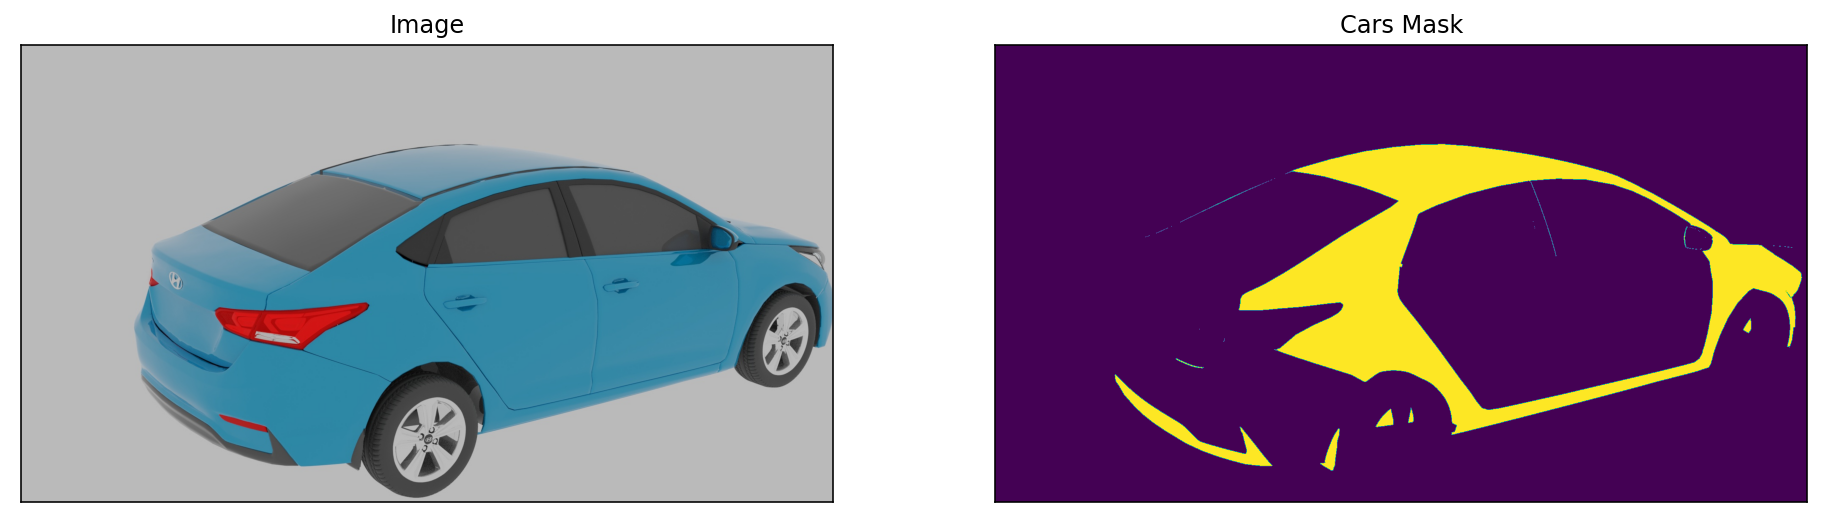

In [ ]:
dataset = Dataset(data_dir, classes=[2])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

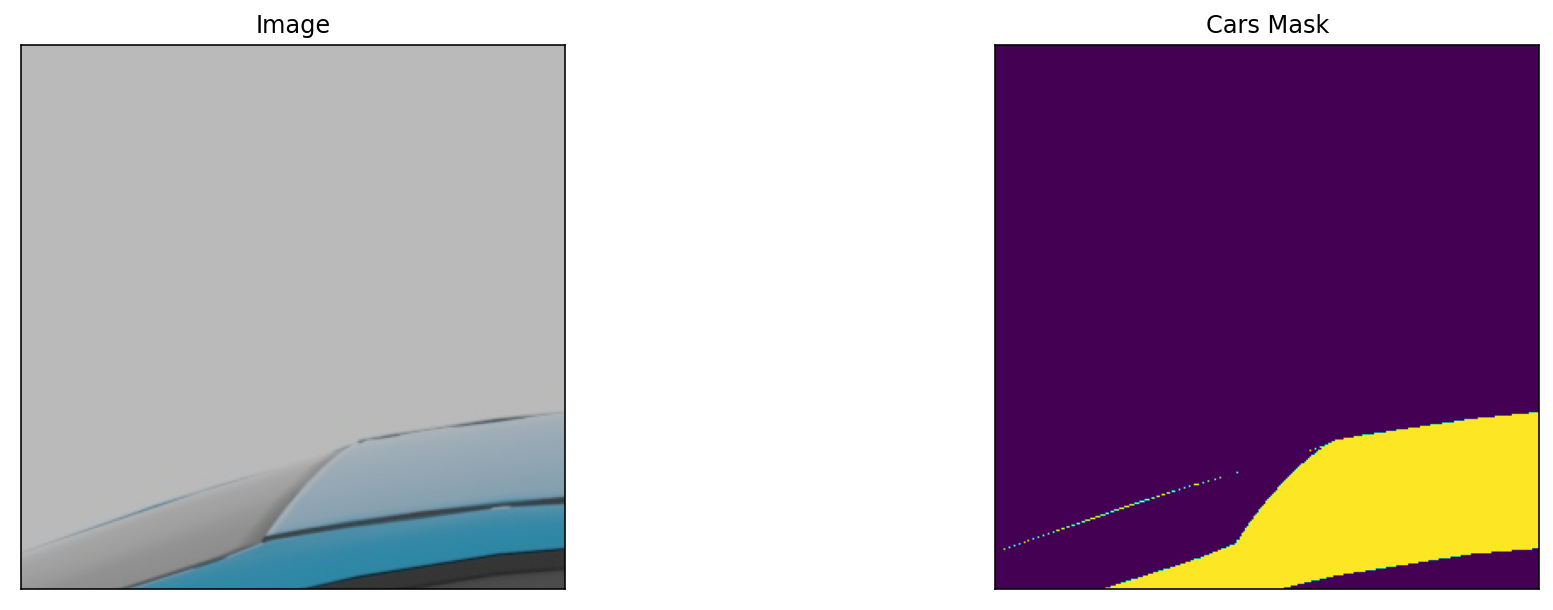

In [ ]:
dataset = Dataset(data_dir, classes=[2], 
                  augmentation=segmentation.get_training_augmentation())
image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [12]:
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

DEVICE = 'cuda'

model, train_loader, valid_loader = segmentation.get_model_and_loaders(data_dir, train_idx, val_idx, CLASSES, DEVICE)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# create epoch runners 
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [13]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0003),
])

In [ ]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [ ]:
import warnings
max_score = valid_epoch.run(valid_loader)['iou_score']
torch.cuda.empty_cache()

epochs = 100

for epoch in range(1, epochs+1):
    
    print(f'\nEpoch: {epoch}')
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, base_dir / 'saved models/best_model_segmentation.pth')
        print('Model saved!')
    else:
        torch.save(model, base_dir / 'saved models/model_segmentation_last_save.pth')

valid: 100%|██████████| 246/246 [01:24<00:00,  2.92it/s, dice_loss - 0.1206, iou_score - 0.7981]

Epoch: 1
valid: 100%|██████████| 246/246 [01:24<00:00,  2.90it/s, dice_loss - 0.128, iou_score - 0.7873]

Epoch: 2
valid: 100%|██████████| 246/246 [01:25<00:00,  2.89it/s, dice_loss - 0.1224, iou_score - 0.7944]

Epoch: 3
valid: 100%|██████████| 246/246 [01:25<00:00,  2.89it/s, dice_loss - 0.1106, iou_score - 0.811]
Model saved!

Epoch: 4
valid: 100%|██████████| 246/246 [01:25<00:00,  2.87it/s, dice_loss - 0.1312, iou_score - 0.7782]

Epoch: 5
valid: 100%|██████████| 246/246 [01:25<00:00,  2.88it/s, dice_loss - 0.1153, iou_score - 0.8067]

Epoch: 6
valid: 100%|██████████| 246/246 [01:25<00:00,  2.88it/s, dice_loss - 0.165, iou_score - 0.7342]

Epoch: 7
valid: 100%|██████████| 246/246 [01:25<00:00,  2.88it/s, dice_loss - 0.114, iou_score - 0.8075]

Epoch: 8
valid: 100%|██████████| 246/246 [01:25<00:00,  2.88it/s, dice_loss - 0.1506, iou_score - 0.7525]

Epoch: 9
valid: 100%|██████████| 246/

## Testing

In [6]:
# load best saved checkpoint
best_model = torch.load(base_dir / 'saved models' / 'best_model_segmentation.pth')

In [21]:
# create test dataset
test_dataset = Dataset(
    data_dir, 
    CLASSES,
    test_idx, 
    augmentation=segmentation.get_validation_augmentation(), 
    preprocessing=segmentation.get_preprocessing(None),
)

test_dataloader = DataLoader(test_dataset, num_workers=2)

In [15]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 370/370 [02:57<00:00,  2.08it/s, dice_loss - 0.1022, iou_score - 0.8265]


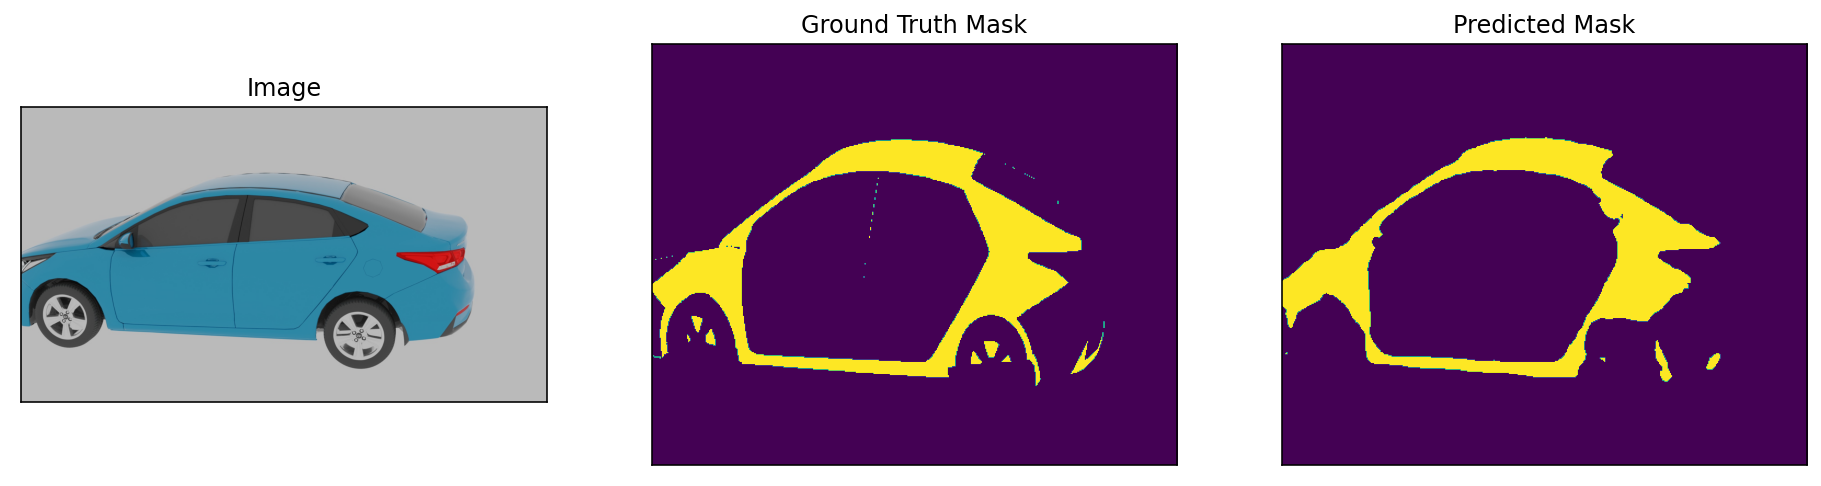

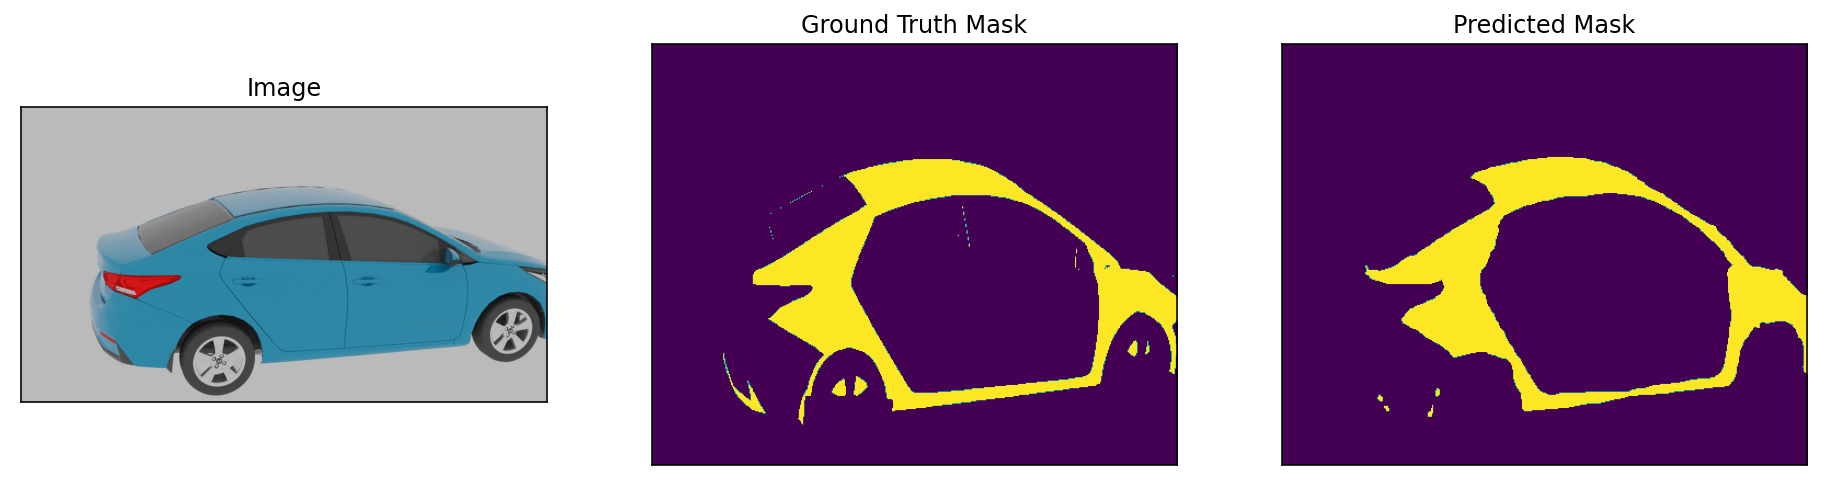

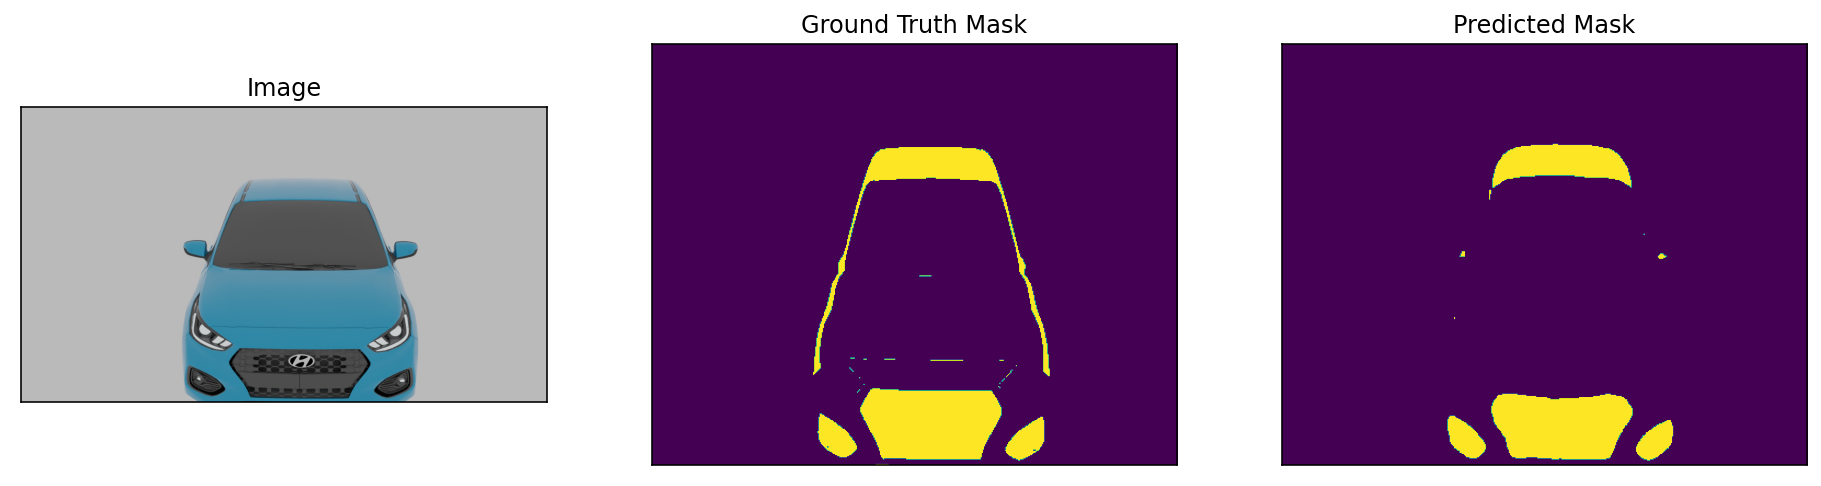

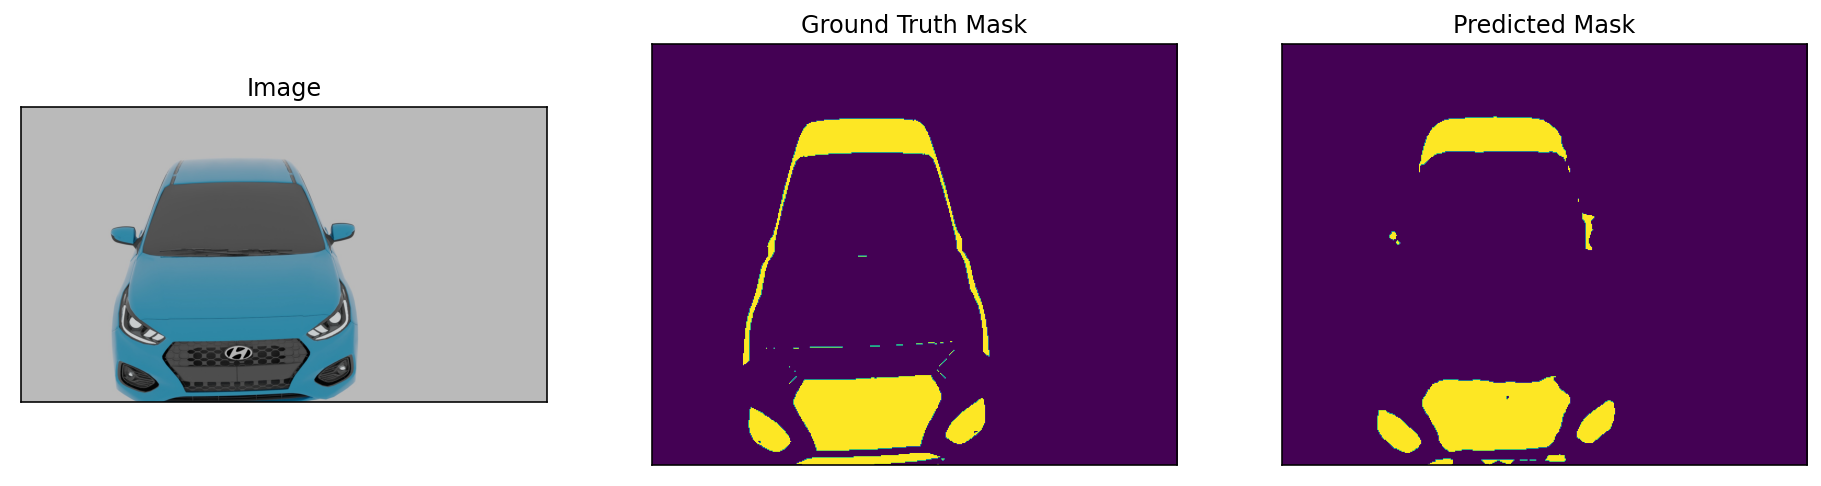

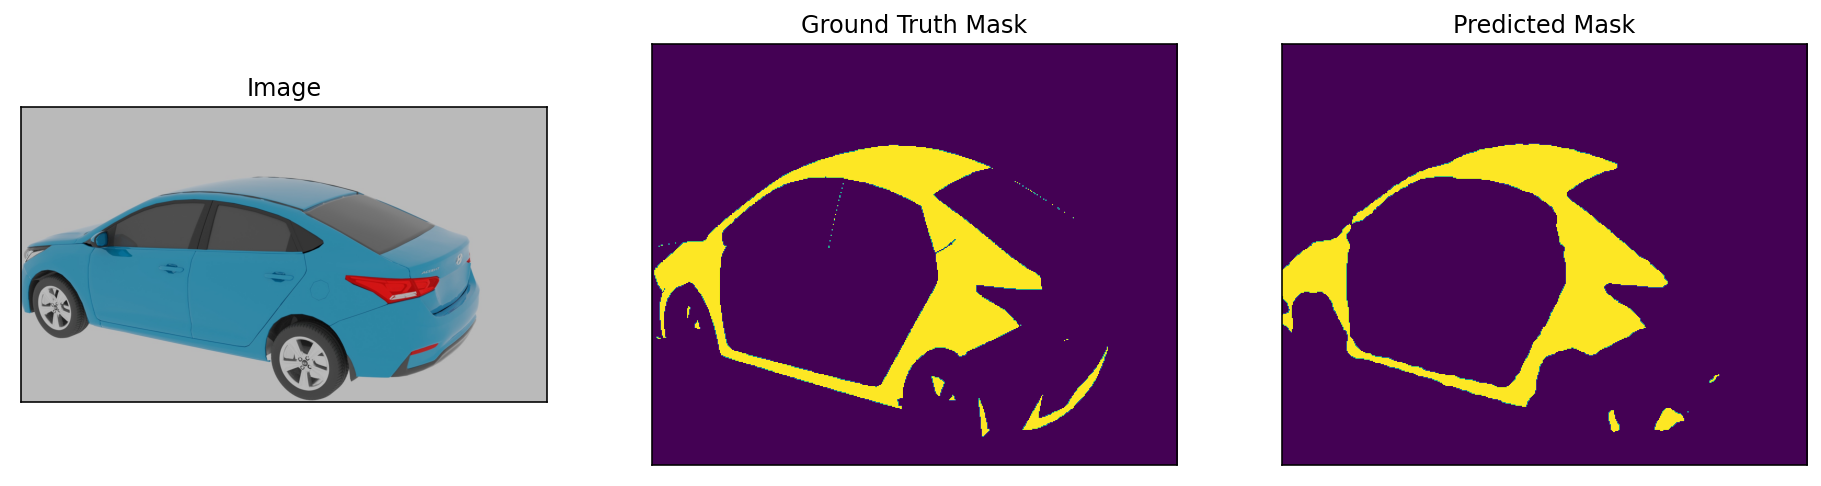

In [22]:
# test dataset without transformations for image visualization
cls = 2

test_dataset_vis = Dataset(
    data_dir,
    [cls],
    test_idx,
)

for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask[CLASSES.index(cls)].squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask = pr_mask[CLASSES.index(cls)]
    
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

## Irl testing

In [24]:
data_irl_dir = base_dir / 'data' / 'irl car validation'
# create test dataset
test_irl_dataset = Dataset(
    data_irl_dir, 
    CLASSES,
    augmentation=segmentation.get_validation_augmentation(), 
    preprocessing=segmentation.get_preprocessing(None),
)

test_irl_dataloader = DataLoader(test_irl_dataset, num_workers=2)

In [25]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_irl_dataloader)

valid: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s, dice_loss - 0.9199, iou_score - 0.04379]


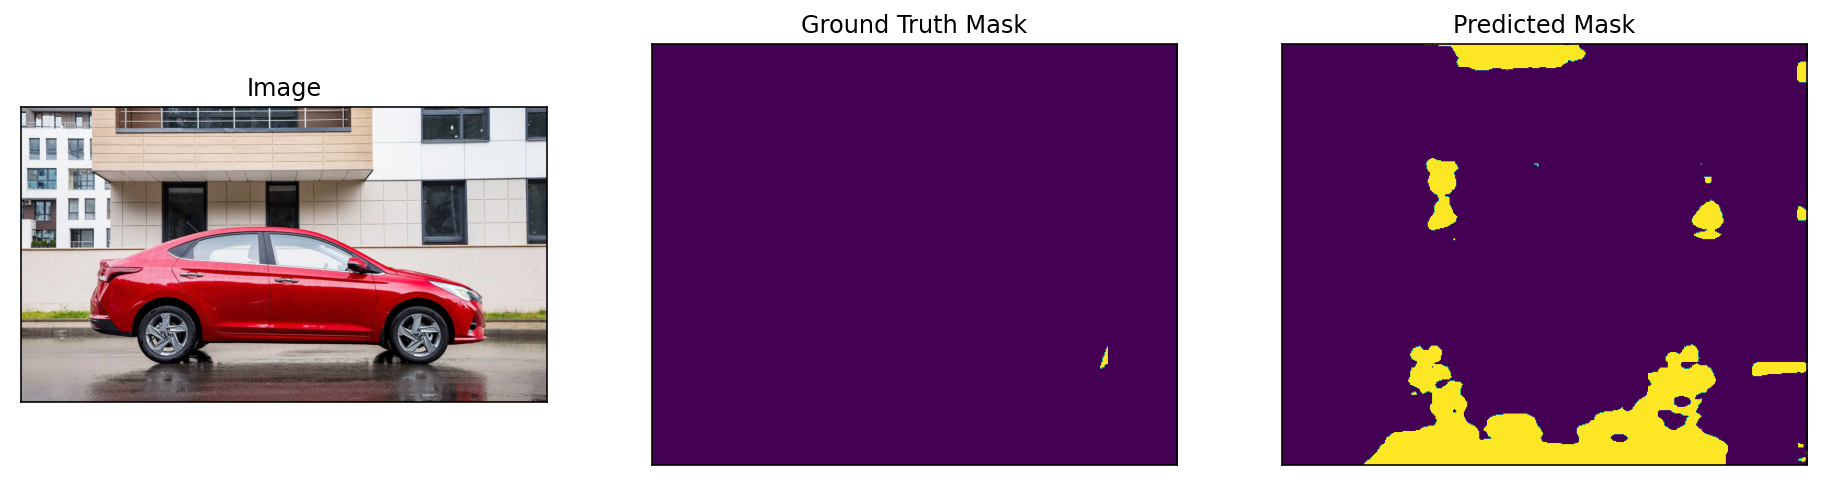

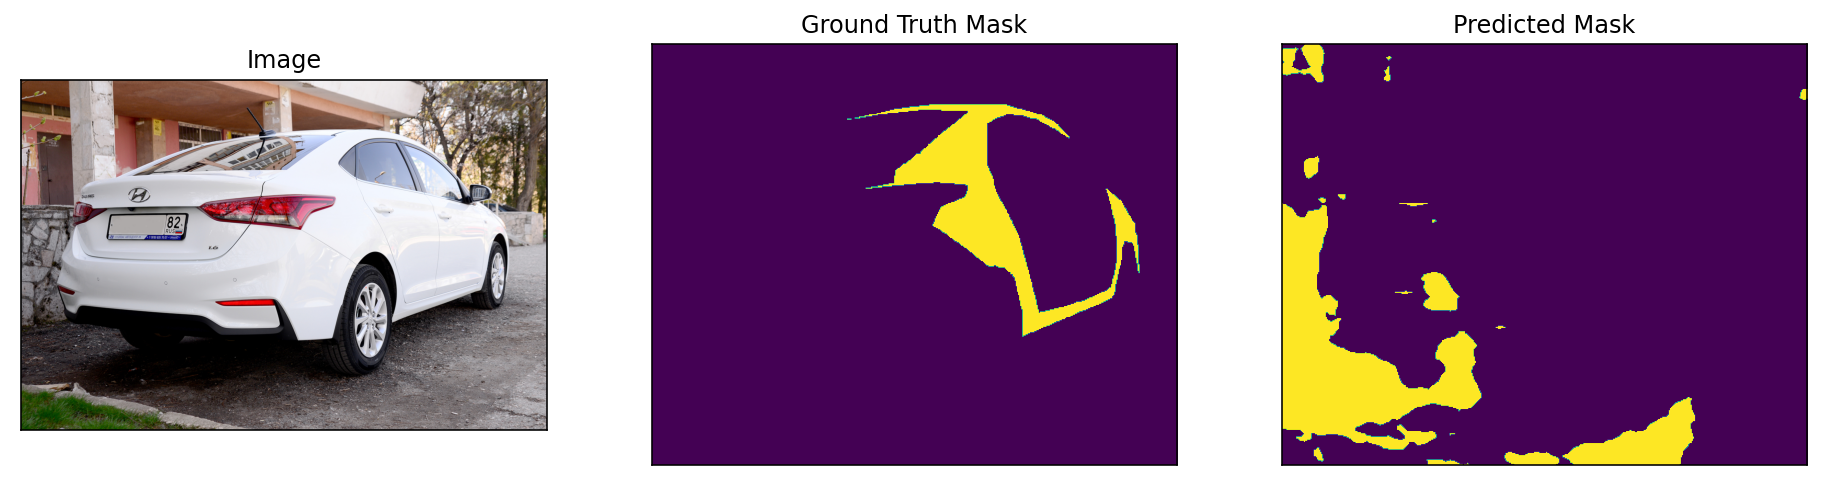

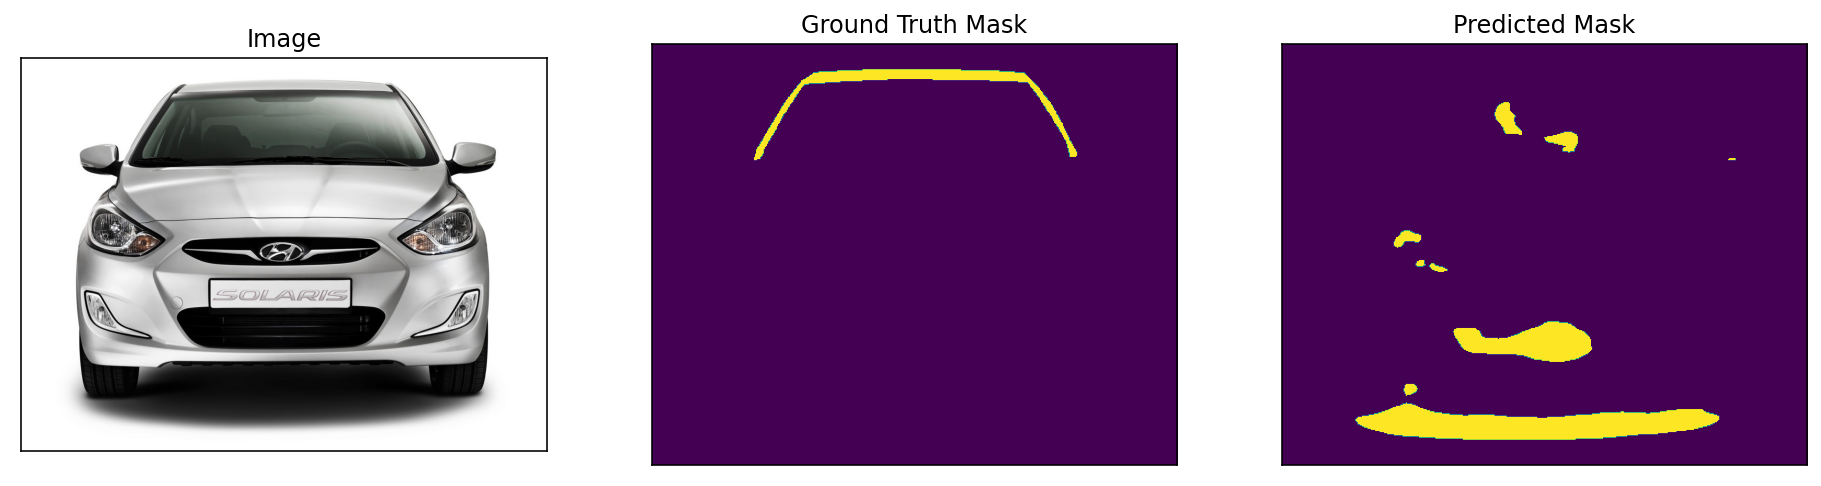

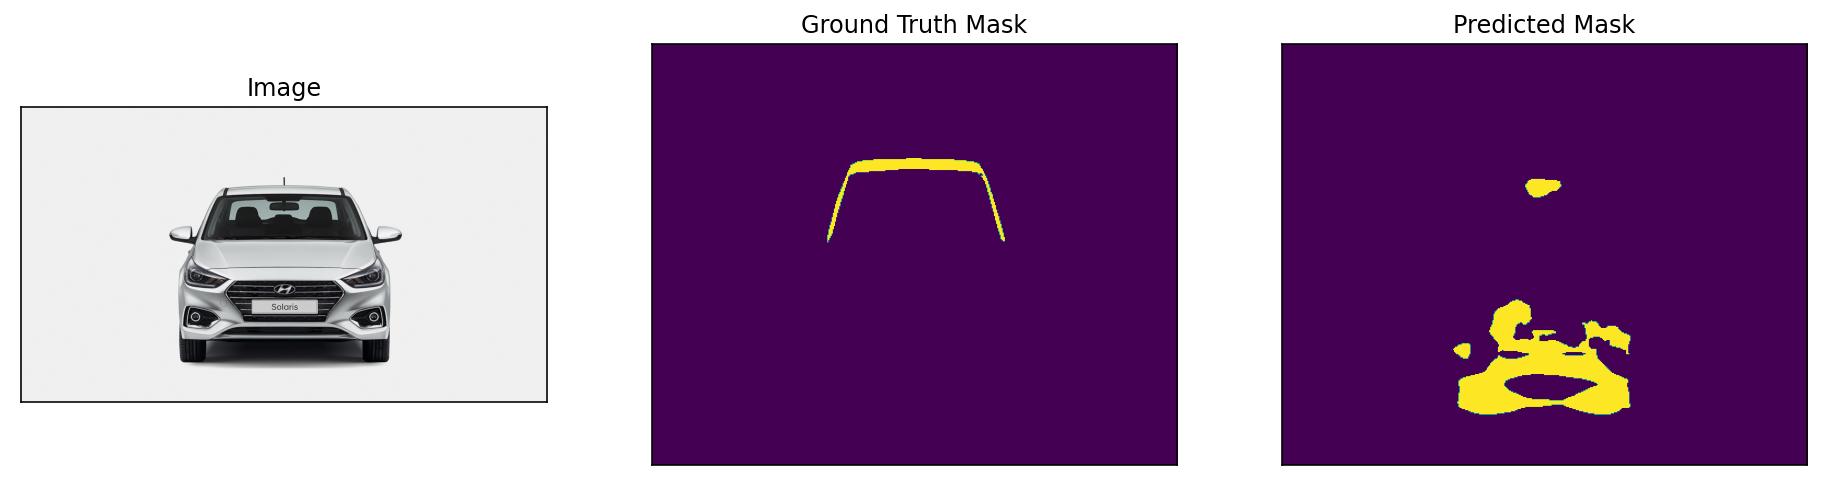

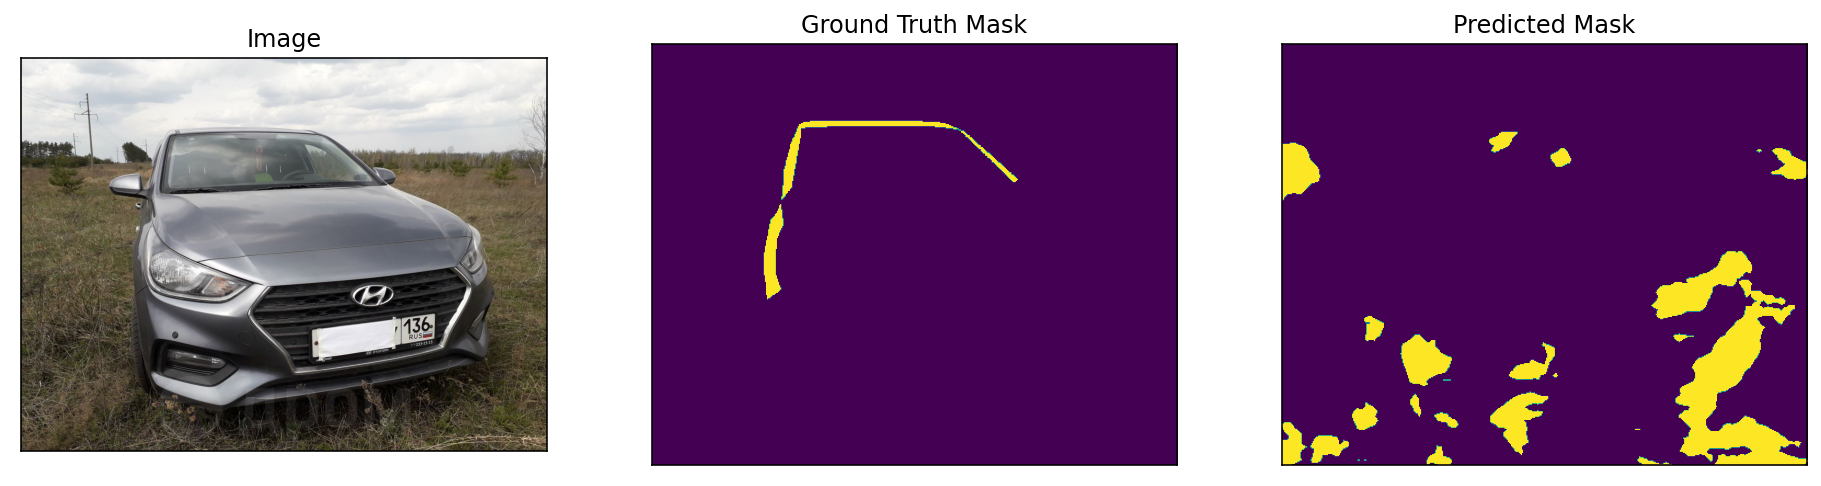

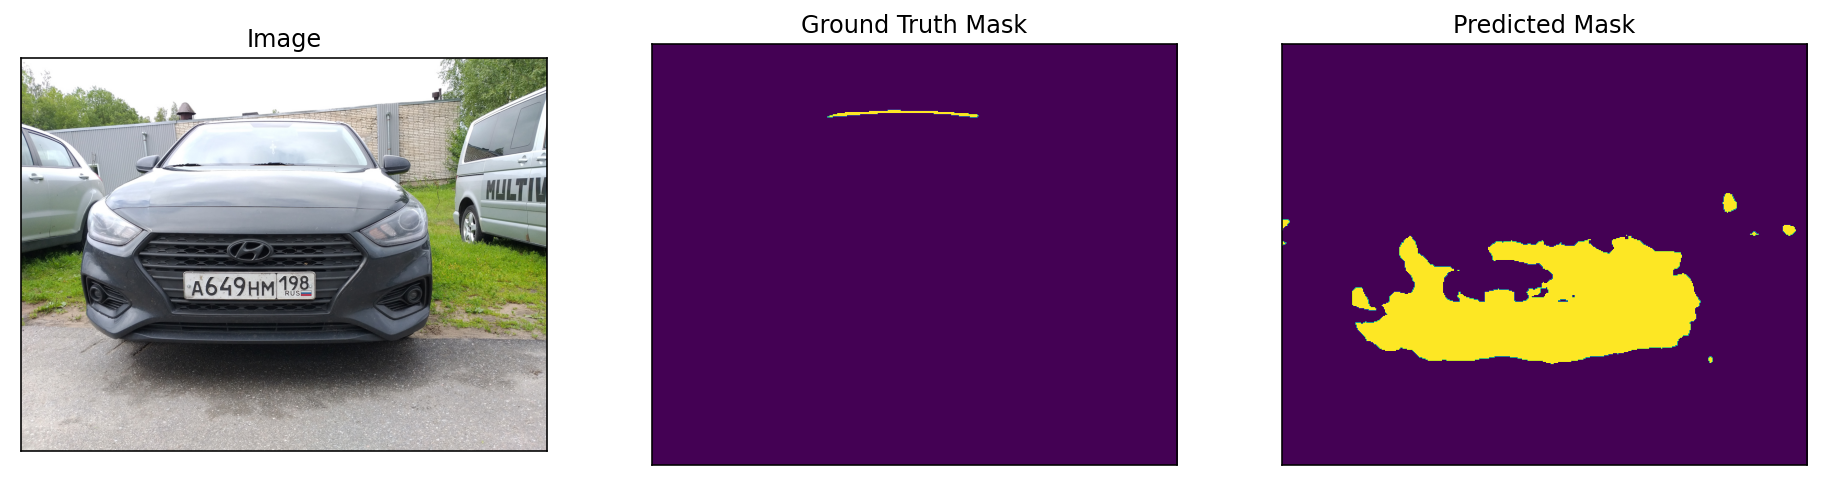

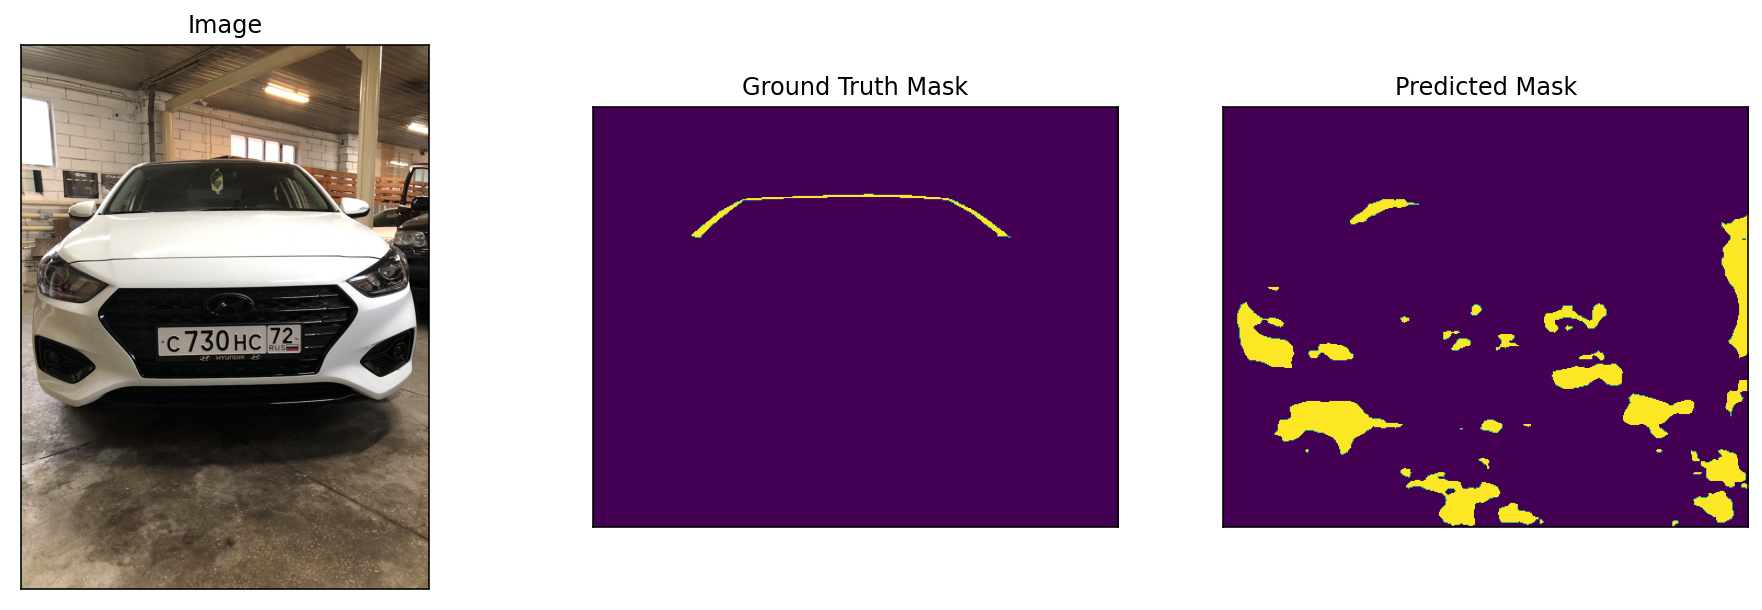

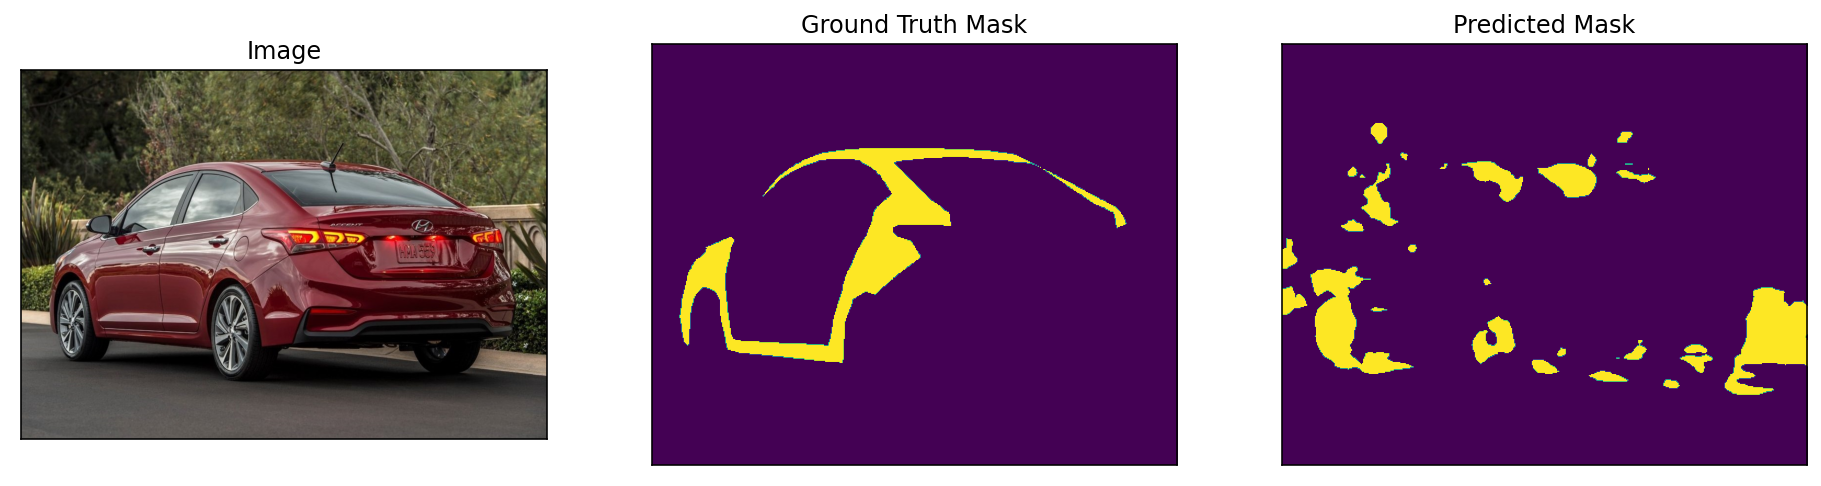

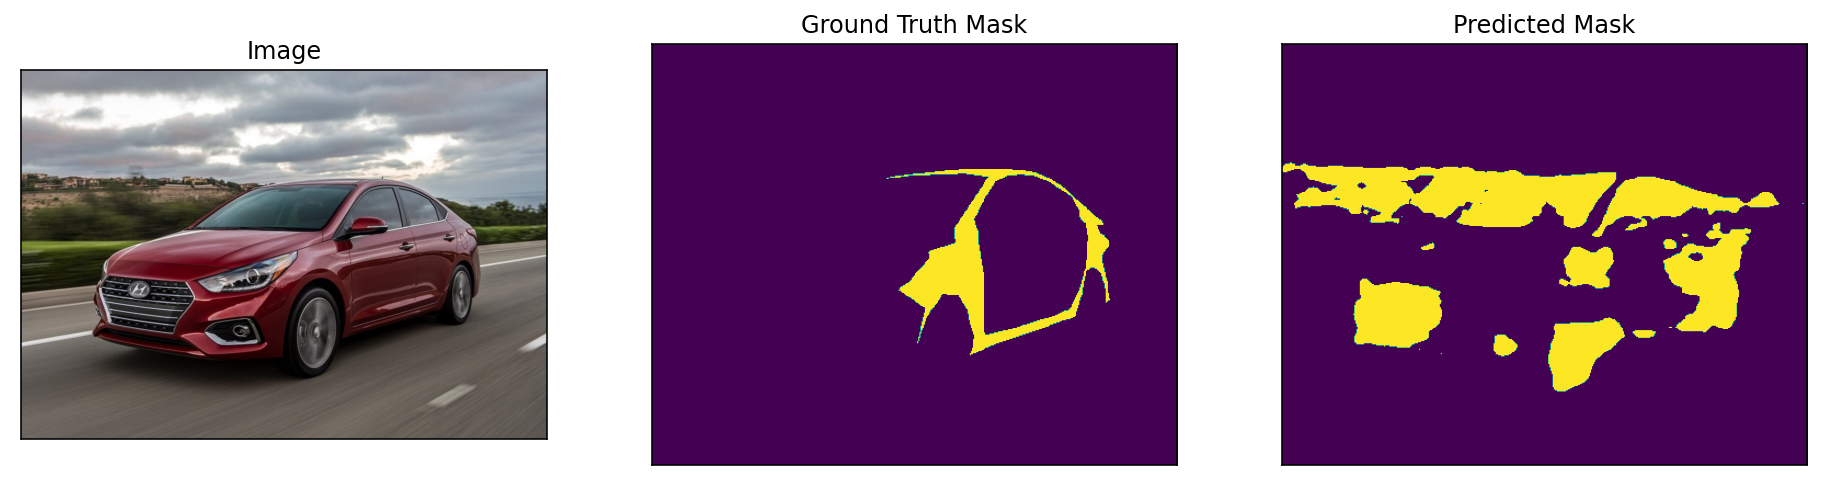

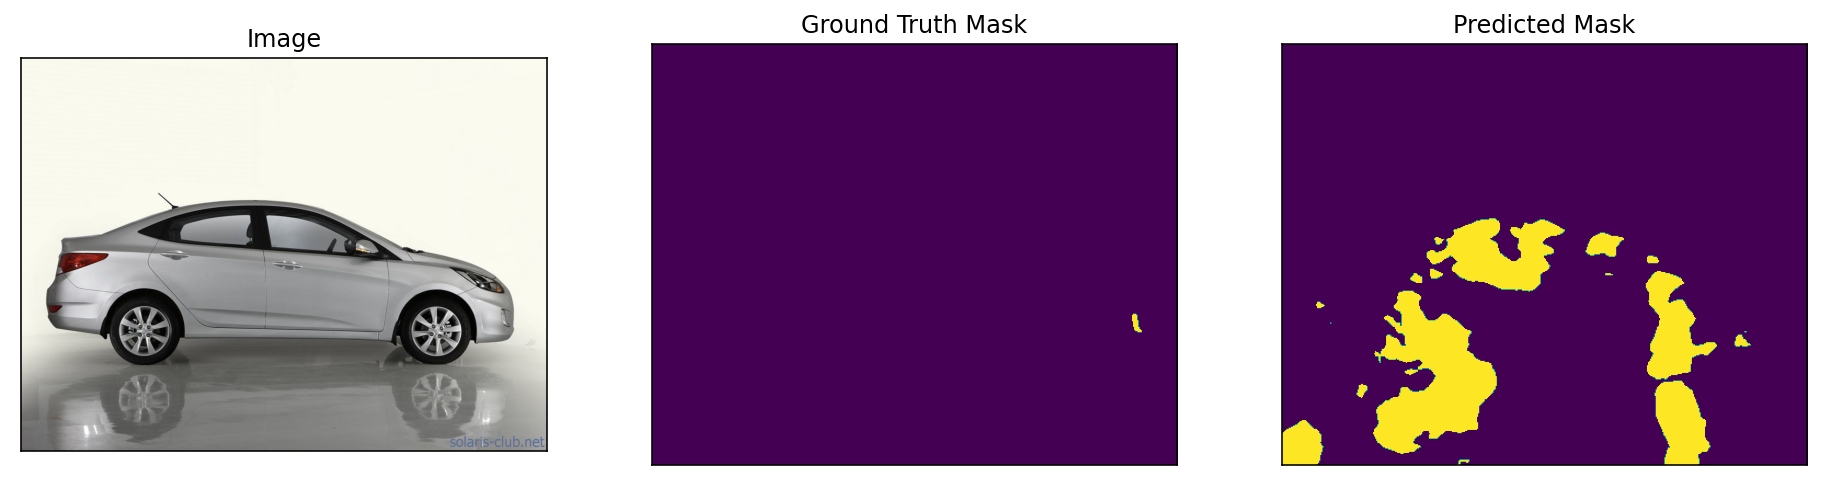

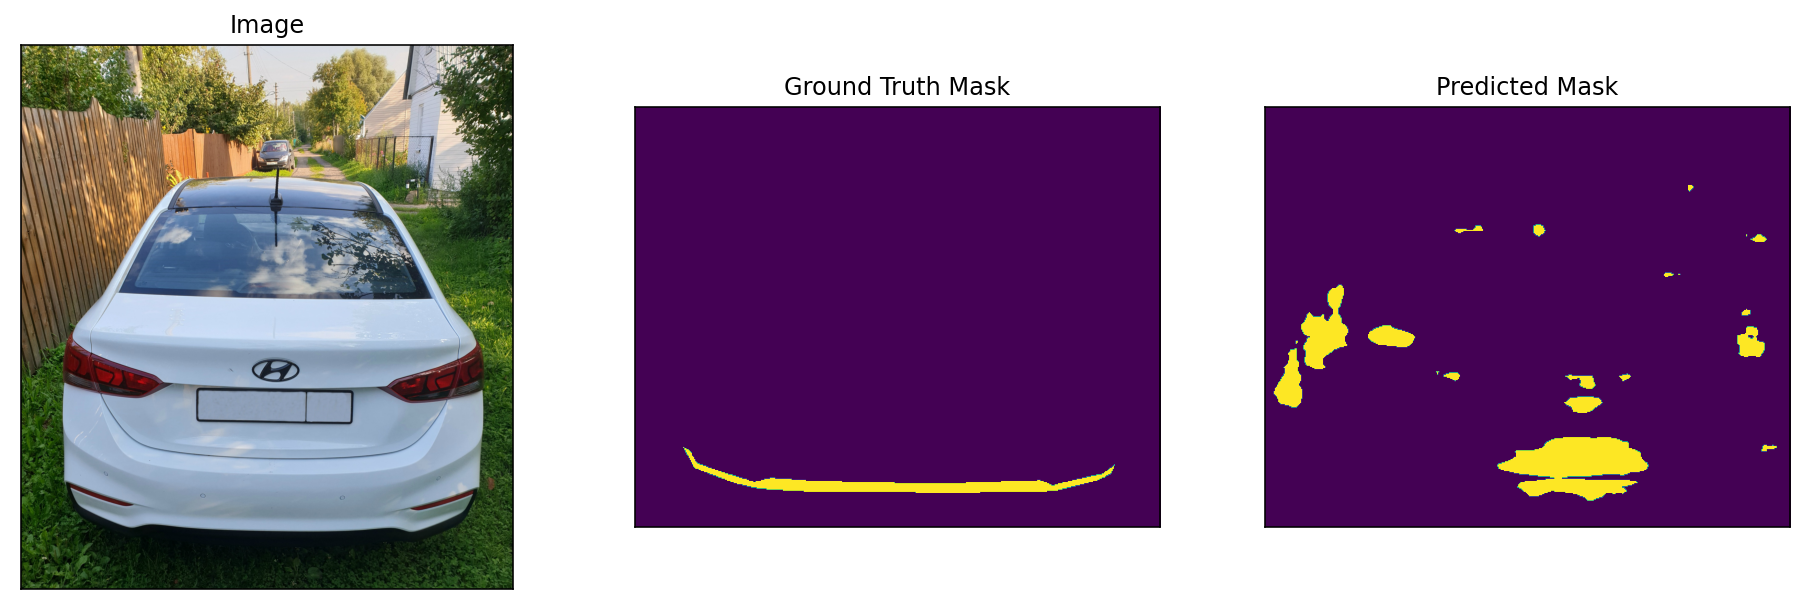

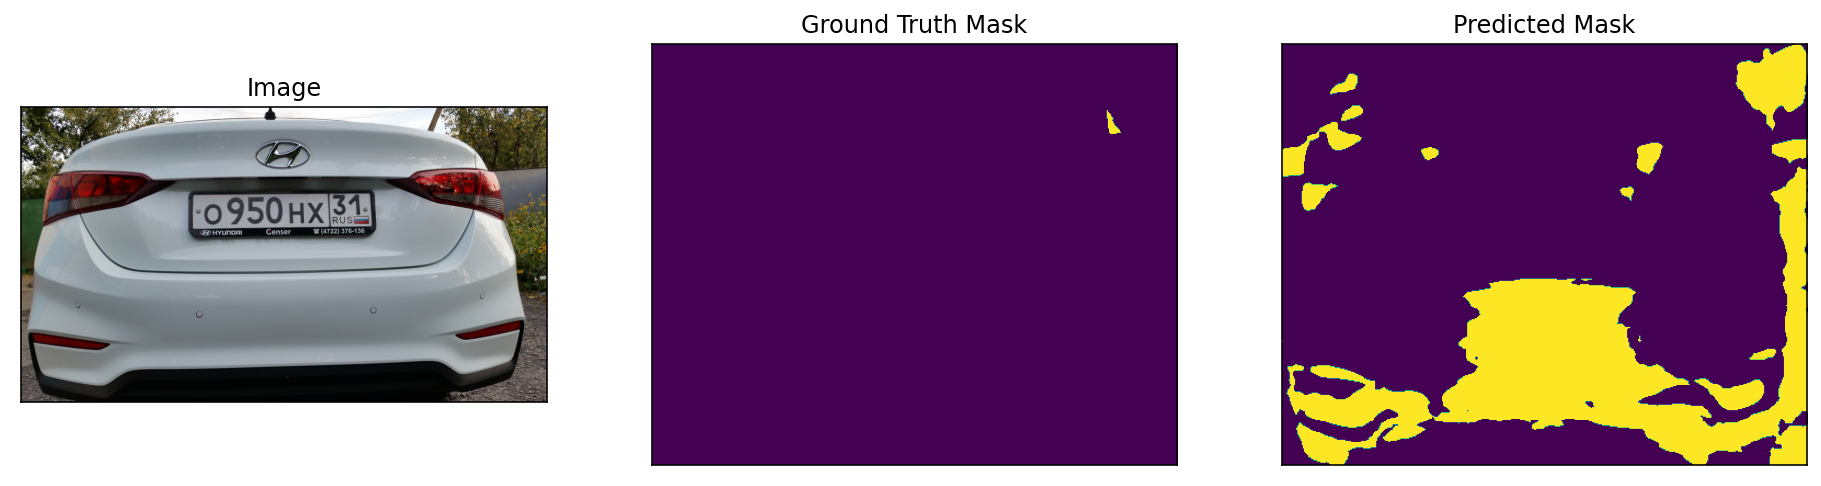

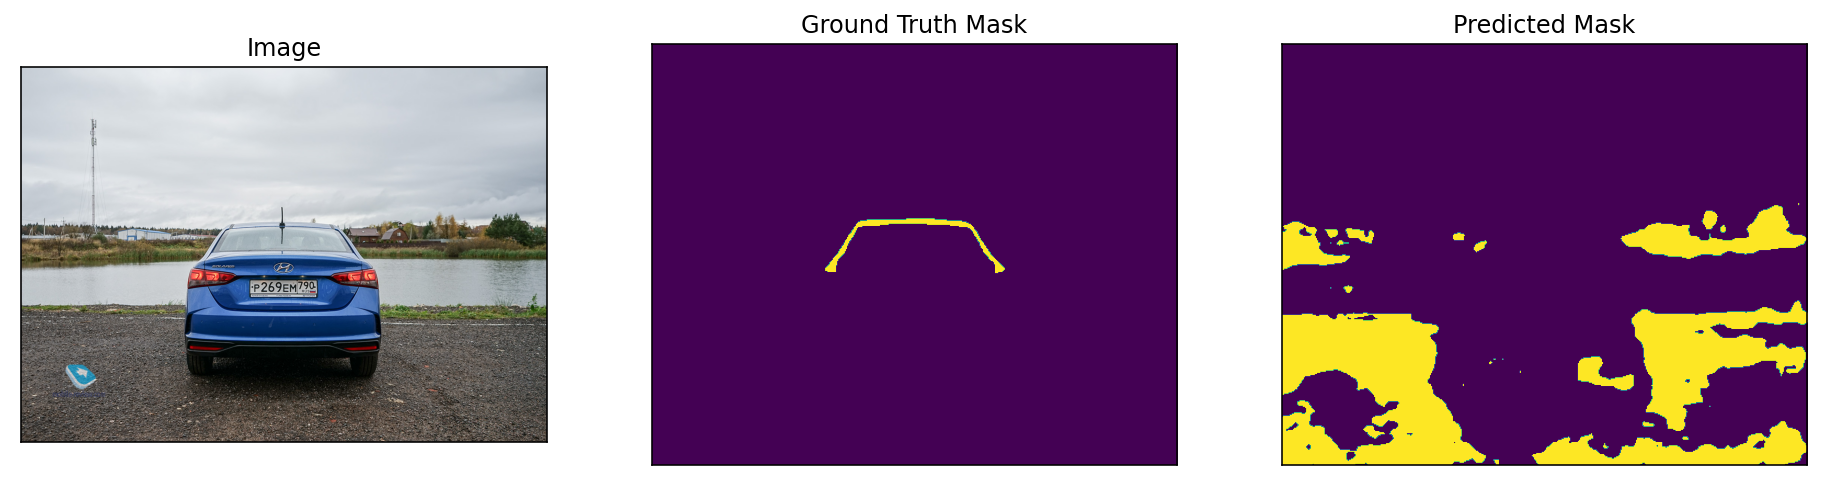

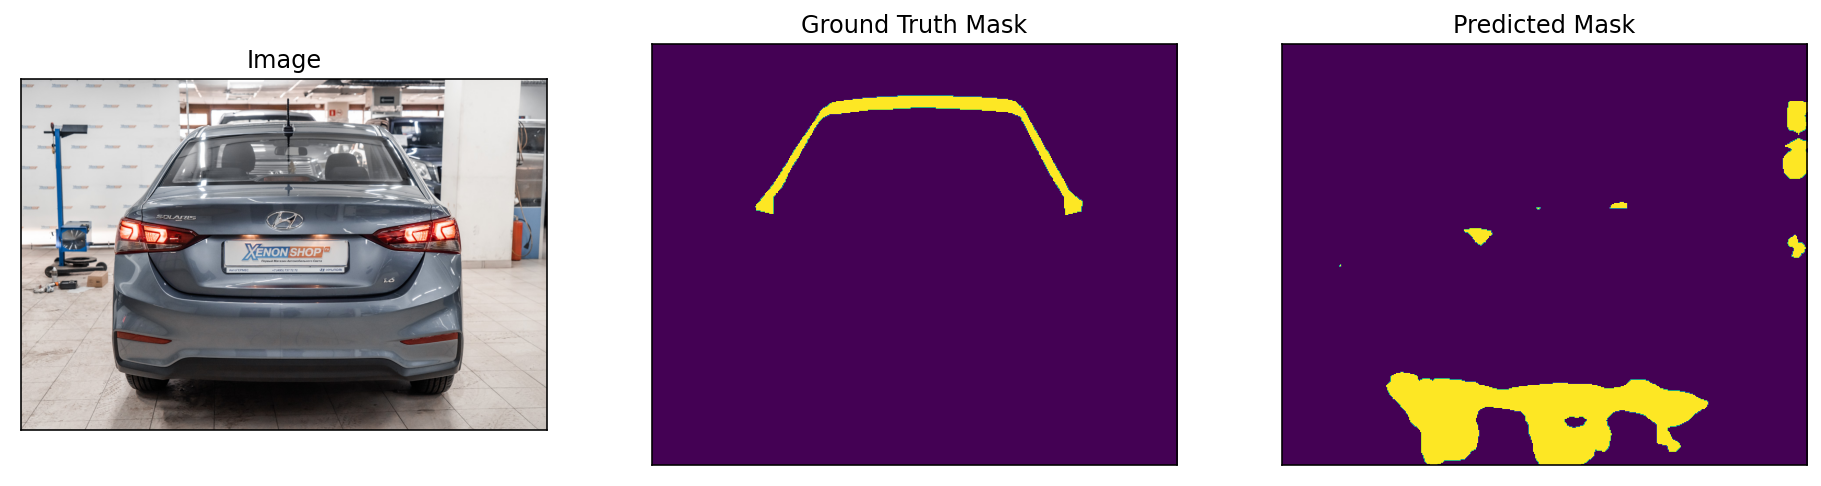

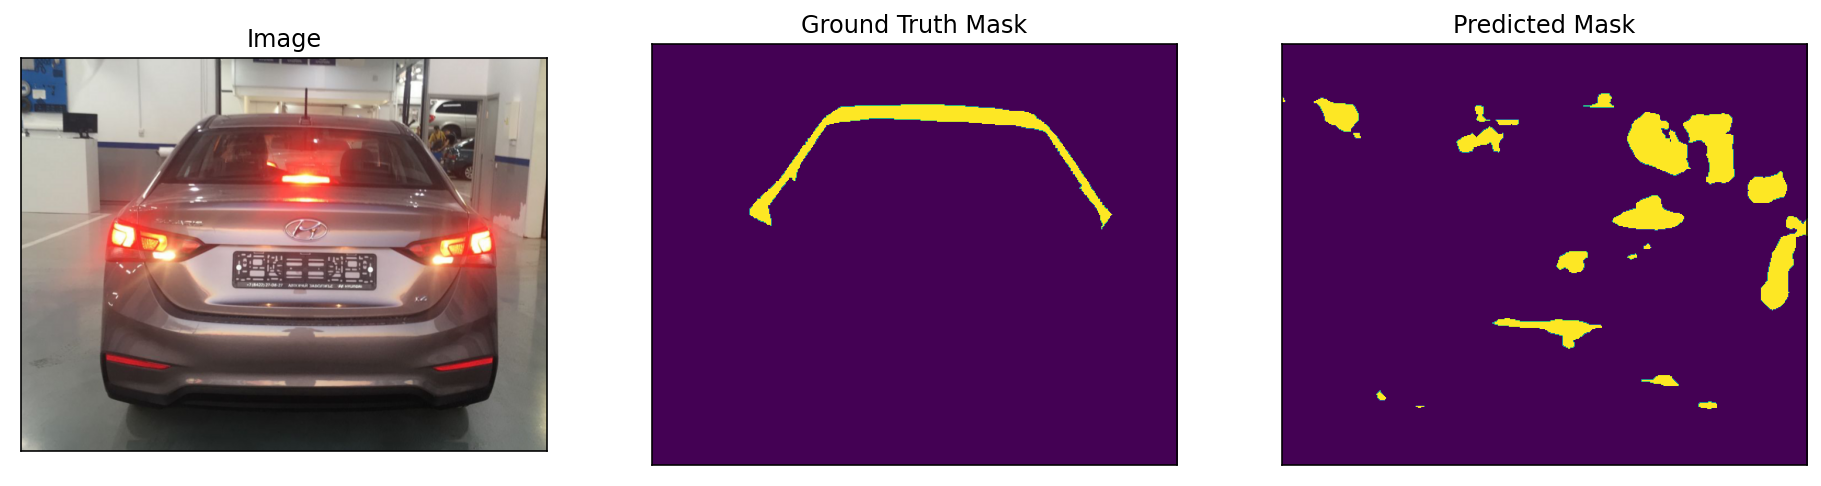

In [29]:
# test dataset without transformations for image visualization
cls = 2

test_irl_dataset_vis = Dataset(
    data_irl_dir,
    [cls],
)

for i in range(len(test_irl_dataset_vis)):
    
    image_vis = test_irl_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_irl_dataset[i]
    
    gt_mask = gt_mask[CLASSES.index(cls)].squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask = pr_mask[CLASSES.index(cls)]
    
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )